In [1]:
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras import optimizers
import random
from skimage import measure
from skimage import util 
from skimage.util import random_noise

Using TensorFlow backend.


In [2]:
 # We do not require the ground truth labelled data, hence not loading the y labels neither fro training nor for testing
    
(x_trainb,_), (x_testb,_) = mnist.load_data()

print(x_trainb.shape)
print(x_testb.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


In [0]:
# taking inversion of mnist images
x_train = util.invert(x_trainb)
x_test = util.invert(x_testb)

In [0]:
# Normalizing the pixel value between [0, 1]

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') /255.

# Reshaping the images 

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))


In [6]:
# Creating function for gaussian noise
def gaussian_noise(image,mean,variance):
    img_noisy = image +  0.5 * np.random.normal(loc=mean, scale=variance, size = image.shape)
    return img_noisy

# Creating function for poisson noise
def poisson(image):
    p_noise = np.random.poisson(image)
    return p_noise

# Creating function for salt and paper noise

'''def sp_noise(x_img,prob):
    x_noise = np.zeros(x_img.shape,np.uint8)
    thres = 1 - prob 
    for i in range(x_img.shape[0]):
        for j in range(x_img.shape[1]):
            rdn = random.random()
            if rdn < prob:
                x_noise[i][j] = 0.0
            elif rdn > thres:
                x_noise[i][j] = 255.0
            else:
                x_noise[i][j] = x_img[i][j]
    return x_noise'''

    

'def sp_noise(x_img,prob):\n    x_noise = np.zeros(x_img.shape,np.uint8)\n    thres = 1 - prob \n    for i in range(x_img.shape[0]):\n        for j in range(x_img.shape[1]):\n            rdn = random.random()\n            if rdn < prob:\n                x_noise[i][j] = 0.0\n            elif rdn > thres:\n                x_noise[i][j] = 255.0\n            else:\n                x_noise[i][j] = x_img[i][j]\n    return x_noise'

In [0]:
x_train_1 = x_train[0:20000]
x_train_2 = x_train[20000:40000]
x_train_3 = x_train[40000:60000]

In [0]:
# Creating MNIST training images with Gaussian, Poisson and SnP noises

noise_mask = np.zeros(x_train_2.shape)

x_train_noise_G = []
x_train_noise_P = np.zeros(x_train_2.shape)
x_train_noise_SnP = np.zeros(x_train_3.shape)

for i in range(len(x_train_1)):
    x_train_noise_G.append(np.abs(gaussian_noise(x_train_1[i], mean=0.0, variance=0.3)))
x_train_noise_G = np.array(x_train_noise_G) 

for i in range (len(x_train_2)):
    noise_mask = np.random.poisson(x_train_2[i])
    x_train_noise_P[i] = x_train_2[i] + noise_mask

for i in range (len(x_train_3)):
    x_train_noise_SnP[i] = random_noise(x_train_3[i], mode = 's&p', amount = 0.3)
    
x_train_noise_SnP = np.array(255*x_train_noise_SnP, dtype = 'uint8')
    #noise_img = random_noise(img, mode='s&p',amount=0.3)
    #noise_img = np.array(255*noise_img, dtype = 'uint8')

In [12]:
print(x_train_noise_G.shape)
print(x_train_noise_P.shape)
print(x_train_noise_SnP.shape)

(20000, 28, 28, 1)
(20000, 28, 28, 1)
(20000, 28, 28, 1)


In [0]:
# Creating MNIST test images with Gaussian, Poisson and SnP noises

x_test_noise_G = []

for i in range(len(x_test)):
    x_test_noise_G.append(np.abs(gaussian_noise(x_test[i], mean=0.0, variance=0.3)))
x_test_noise_G = np.array(x_test_noise_G) 


x_test_noise_P = np.zeros(x_test.shape)
noise_mask = np.zeros(x_test.shape)

for i in range (len(x_test)):
    noise_mask = np.random.poisson(x_test[i])
    x_test_noise_P[i] = x_test[i] + noise_mask


x_test_noise_SnP = np.zeros(x_test.shape)

for i in range (len(x_test)):
    x_test_noise_SnP[i] = random_noise(x_test[i], mode = 's&p', amount = 0.3)
x_test_noise_SnP = np.array(255*x_test_noise_SnP, dtype = 'uint8')

In [16]:
print(x_test_noise_P.shape)
print(x_test_noise_G.shape)
print(x_test_noise_SnP.shape)


(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)


In [17]:
print(x_train_noise_P.shape)
print(x_train_noise_G.shape)
print(x_train_noise_SnP.shape)

(20000, 28, 28, 1)
(20000, 28, 28, 1)
(20000, 28, 28, 1)


In [18]:
# Stacking images with different types of noises to create noisy image dataset

x_train_noisy = np.vstack((x_train_noise_G, x_train_noise_P, x_train_noise_SnP)) # SnP noise missing
x_train_noisy.shape

(60000, 28, 28, 1)

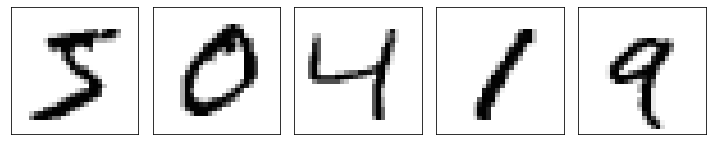

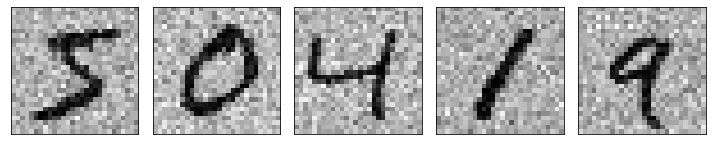

In [21]:
# Plotting first 5 images of noiseless and noisy MNIST image dataset

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_noisy[i].reshape(28, 28), cmap='gray')
plt.tight_layout()
plt.show()


In [22]:
# Creating the model

model = Sequential()

# Encoding (or Compressing) images
model.add(Conv2D(32,(3,3), activation = 'relu', padding = 'same', input_shape = (28, 28, 1)))
# 32 -> dimentionality of the output space, relu -> activation function, padding is 'same' that results in padding the 
# input such that the output has the same length as the original input
model.add(MaxPooling2D((2,2), padding = 'same'))
# Downscaling by a factor of 2x2
model.add(Conv2D(8,(3,3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D((2,2), padding = 'same'))
model.add(Conv2D(8,(3,3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D((2,2), padding = 'same'))

# Decoding (or Decompressing) images
model.add(Conv2D(8,(3,3), activation = 'relu', padding = 'same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(8,(3,3), activation = 'relu', padding = 'same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(32,(3,3), activation = 'relu'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(1,(3,3), activation = 'relu', padding = 'same'))


model.compile(optimizer='adam', loss = 'mean_squared_error')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         2312      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 8)           5

In [0]:
#Compiling the model

from tensorflow.keras.callbacks import EarlyStopping
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

In [25]:
# Training the model on noisy data
 
model.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noise_G, x_test),
                callbacks=[early_stopper])

Epoch 1/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1170 - val_loss: 0.0585
Epoch 2/100
469/469 [==============================] - 2s 5ms/step - loss: 0.0560 - val_loss: 0.0409
Epoch 3/100
469/469 [==============================] - 2s 5ms/step - loss: 0.0458 - val_loss: 0.0343
Epoch 4/100
469/469 [==============================] - 2s 5ms/step - loss: 0.0409 - val_loss: 0.0307
Epoch 5/100
469/469 [==============================] - 3s 5ms/step - loss: 0.0378 - val_loss: 0.0277
Epoch 6/100
469/469 [==============================] - 2s 5ms/step - loss: 0.0354 - val_loss: 0.0260
Epoch 7/100
469/469 [==============================] - 2s 5ms/step - loss: 0.0337 - val_loss: 0.0244
Epoch 8/100
469/469 [==============================] - 2s 5ms/step - loss: 0.0324 - val_loss: 0.0236
Epoch 9/100
469/469 [==============================] - 2s 5ms/step - loss: 0.0315 - val_loss: 0.0225
Epoch 10/100
469/469 [==============================] - 2s 5ms/step - loss: 0.0308 - val_lo

In [26]:
# Saving model parameters 
model.save('DenoisingAutoencoder.model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: DenoisingAutoencoder.model/assets


In [0]:
# Predicting (denoising) images with Poisson noise
x_pred_P = model.predict(x_test_noise_P)

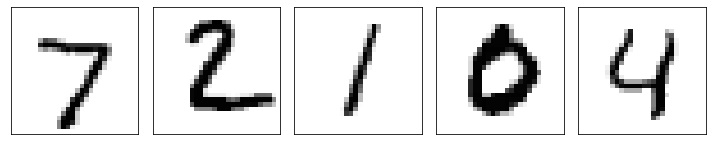

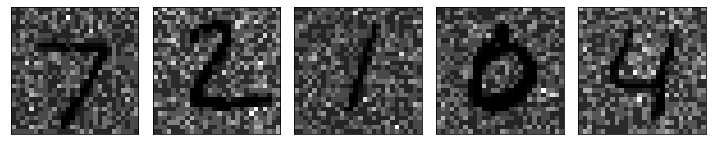

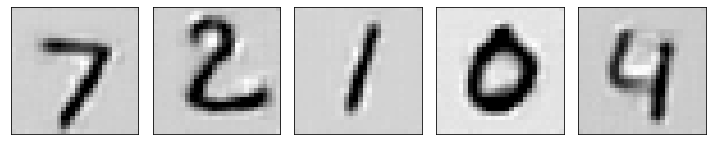

<Figure size 432x288 with 0 Axes>

In [36]:
## Plot the denoised images (Poisson noise) from autoencoders


# Plotting noiseless images
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([]) # to remove x-axis  the [] empty list indicates this
    plt.yticks([]) # to remove y-axis
    plt.grid(False) # to remove grid
    #plt.title('Clean Test Images', fontsize=10)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray') #display the image 
plt.tight_layout() # to have a proper space in the subplots
plt.show()


# Plotting images with noise
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([]) # to remove x-axis  the [] empty list indicates this
    plt.yticks([]) # to remove y-axis
    plt.grid(False) # to remove grid
    #plt.title('Images corrupted with Poisson Noise', fontsize=10)
    plt.imshow(x_test_noise_P[i].reshape(28, 28), cmap='gray') #display the image 
plt.tight_layout() # to have a proper space in the subplots
plt.show()

# Plotting to visualize reconstructed images(output of autoencoder)
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([]) # to remove x-axis  the [] empty list indicates this
    plt.yticks([]) # to remove y-axis
    plt.grid(False) # to remove grid
    #plt.title('Predicted Images by Autoencoder', fontsize=10)
    plt.imshow(x_pred_P[i].reshape(28, 28), cmap='gray') #display the image 
plt.tight_layout() # to have a proper space in the subplots
plt.show()
plt.savefig("Denoising Autoencoder + Poisson Noise", bbox_inches='tight', format = 'png')

In [37]:
# Calculating the SSIM and PSNR of denoised images (Poisson Noise)
#using Autoencoder

ssim_aeP_mnist = 0
ssim_aeP_mnist_list =[]
psnr_aeP_mnist_list = []
                       

for i in range (len(x_test)):
    ssim_aeP_mnist = measure.compare_ssim(x_pred_P[i], x_test[i],multichannel = True, win_size = None)
    ssim_aeP_mnist_list.append(ssim_aeP_mnist)
    psnr_aeP_mnist = measure.compare_psnr(x_test[i], x_pred_P[i])
    psnr_aeP_mnist_list.append(psnr_aeP_mnist)

print('SSIM of clean test images vs predicted denoised images') 
    
print(np.sum(ssim_aeP_mnist_list)/len(ssim_aeP_mnist_list))
print('PSNR of clean test images vs predicted denoised images') 
print(np.sum(psnr_aeP_mnist_list)/len(psnr_aeP_mnist_list))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  if __name__ == '__main__':


SSIM of clean test images vs predicted denoised images
0.8629542301299049
PSNR of clean test images vs predicted denoised images
18.623126146423807


In [0]:
# Predicting (denoising) images with Gaussian noise
x_pred_G = model.predict(x_test_noise_G)

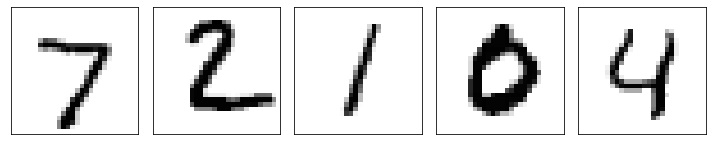

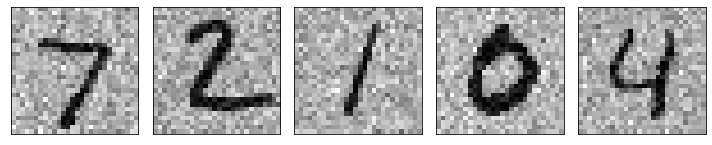

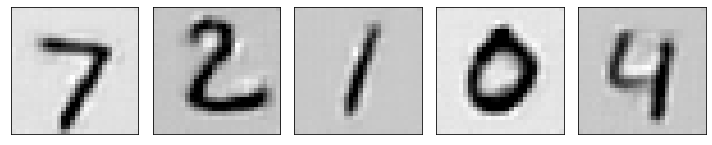

<Figure size 432x288 with 0 Axes>

In [40]:
## Plot the denoised images (Gaussian noise) from autoencoders


# Plotting noiseless images
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([]) # to remove x-axis  the [] empty list indicates this
    plt.yticks([]) # to remove y-axis
    plt.grid(False) # to remove grid
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray') #display the image 
plt.tight_layout() # to have a proper space in the subplots
plt.show()


# Plotting images with noise
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([]) # to remove x-axis  the [] empty list indicates this
    plt.yticks([]) # to remove y-axis
    plt.grid(False) # to remove grid
    plt.imshow(x_test_noise_G[i].reshape(28, 28), cmap='gray') #display the image 
plt.tight_layout() # to have a proper space in the subplots
plt.show()

# Plotting to visualize reconstructed images(output of autoencoder)
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([]) # to remove x-axis  the [] empty list indicates this
    plt.yticks([]) # to remove y-axis
    plt.grid(False) # to remove grid
    plt.imshow(x_pred_G[i].reshape(28, 28), cmap='gray') #display the image 
plt.tight_layout() # to have a proper space in the subplots
plt.show()
plt.savefig("Denoising Autoencoder + Gaussian Noise", bbox_inches='tight', format = 'png')

In [41]:
# Calculating the SSIM and PSNR of denoised images (Gaussian Noise)
#using Autoencoder


ssim_aeG_mnist = 0
ssim_aeG_mnist_list =[]
psnr_aeG_mnist_list = []
                       

for i in range (len(x_test)):
    ssim_aeG_mnist = measure.compare_ssim(x_pred_G[i], x_test[i],multichannel = True, win_size = None)
    ssim_aeG_mnist_list.append(ssim_aeG_mnist)
    psnr_aeG_mnist = measure.compare_psnr(x_test[i], x_pred_G[i])
    psnr_aeG_mnist_list.append(psnr_aeG_mnist)

print('SSIM of clean test images vs predicted denoised images') 
    
print(np.sum(ssim_aeG_mnist_list)/len(ssim_aeG_mnist_list))
print('PSNR of clean test images vs predicted denoised images') 
print(np.sum(psnr_aeG_mnist_list)/len(psnr_aeG_mnist_list))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  if __name__ == '__main__':


SSIM of clean test images vs predicted denoised images
0.863553098788171
PSNR of clean test images vs predicted denoised images
18.58773030306335


In [0]:
# Predicting (denoising) images with SnP noise
x_pred_SnP = model.predict(x_test_noise_SnP)

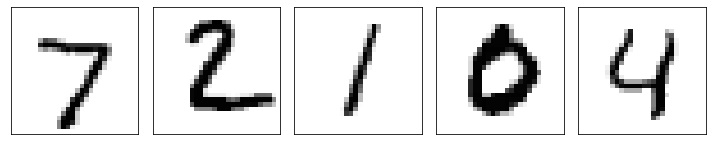

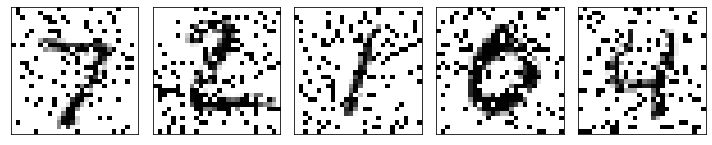

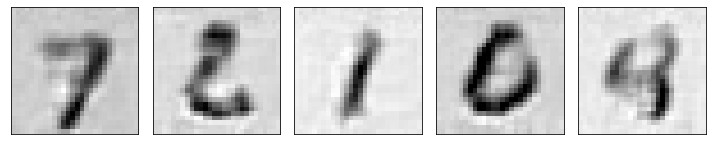

<Figure size 432x288 with 0 Axes>

In [43]:
## Plot the denoised images (SnP noise) from autoencoders


# Plotting noiseless images
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([]) # to remove x-axis  the [] empty list indicates this
    plt.yticks([]) # to remove y-axis
    plt.grid(False) # to remove grid
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray') #display the image 
plt.tight_layout() # to have a proper space in the subplots
plt.show()


# Plotting images with noise
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([]) # to remove x-axis  the [] empty list indicates this
    plt.yticks([]) # to remove y-axis
    plt.grid(False) # to remove grid
    plt.imshow(x_test_noise_SnP[i].reshape(28, 28), cmap='gray') #display the image 
plt.tight_layout() # to have a proper space in the subplots
plt.show()


# Plotting to visualize reconstructed images(output of autoencoder)
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([]) # to remove x-axis  the [] empty list indicates this
    plt.yticks([]) # to remove y-axis
    plt.grid(False) # to remove grid
    plt.imshow(x_pred_SnP[i].reshape(28, 28), cmap='gray') #display the image 
plt.tight_layout() # to have a proper space in the subplots
plt.show()
plt.savefig("Denoising Autoencoder + Salt and Pepper Noise", bbox_inches='tight', format = 'png')

In [44]:
# Calculating the SSIM and PSNR of denoised images (SnP Noise)
#using Autoencoder

ssim_aeSnP_mnist = 0
ssim_aeSnP_mnist_list =[]
psnr_aeSnP_mnist_list = []
                       

for i in range (len(x_test)):
    ssim_aeSnP_mnist = measure.compare_ssim(x_pred_SnP[i], x_test[i],multichannel = True, win_size = None)
    ssim_aeSnP_mnist_list.append(ssim_aeSnP_mnist)
    psnr_aeSnP_mnist = measure.compare_psnr(x_test[i], x_pred_SnP[i])
    psnr_aeSnP_mnist_list.append(psnr_aeSnP_mnist)

print('SSIM of clean test images vs predicted denoised images') 
    
print(np.sum(ssim_aeG_mnist_list)/len(ssim_aeG_mnist_list))
print('PSNR of clean test images vs predicted denoised images') 
print(np.sum(psnr_aeG_mnist_list)/len(psnr_aeG_mnist_list))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  if __name__ == '__main__':


SSIM of clean test images vs predicted denoised images
0.863553098788171
PSNR of clean test images vs predicted denoised images
18.58773030306335
